# CNN
This notebook aims to deploy the CNN.

## Setup for UCloud
The Setup on Ucloud is a bit feasty at times, so here are some workarounds

In [1]:
#pip freeze > requirements.txt

In [5]:
!pip install -r requirements.txt
!pip install matplotlib opencv-python pandas scikit-learn tensorflow
!pip install numpy==1.26.4 --force-reinstall
# also run this in the terminal


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 23.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 77.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 20.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 34.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 60.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [7]:
# sudo apt update && sudo apt install -y libgl1

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


2025-05-19 10:50:02.557844: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 10:50:02.563047: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 10:50:02.576690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747644602.598632     375 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747644602.605261     375 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747644602.623063     375 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

---
## Loading the data
Data has to load out of the 'carolianminuscule-groundtruth'-folder 

In [9]:
def get_images(folder_path: str):
    """
    Load images and text files from the given path.
    :param folder_path: Path to the directory containing images and text files.
    :return: Two lists - one for image paths and one for text file paths.
    """
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Path {folder_path} does not exist.")

    images = []
    files = []

    for entry in os.listdir(folder_path):
        entry_path = os.path.join(folder_path, entry)
        if os.path.isdir(entry_path):
            # Recursively get images and text files from subdirectories
            sub_images, sub_files = get_images(entry_path)
            images.extend(sub_images)
            files.extend(sub_files)
        elif entry.endswith(".png"):
            images.append(entry_path)
        elif entry.endswith(".txt"):
            files.append(entry_path)

    return images, files


# load the data from the directory
path = "carolineminuscule-groundtruth"
images, files = get_images(path)


# matched the .png- and .txt-file in a folder together
matched_list_path = [
    [img, file]
    for img in images
    for file in files
    if os.path.dirname(img) == os.path.dirname(file)
    and os.path.splitext(os.path.splitext(os.path.basename(img))[0])[0]
    == os.path.splitext(os.path.splitext(os.path.basename(file))[0])[0]
]


In [10]:
print(f"len matched: {len(matched_list_path)}")
print(f"matched_list:\n {matched_list_path[1]}")

len matched: 429
matched_list:
 ['carolineminuscule-groundtruth/bsb00046500/0011/010011.bin.png', 'carolineminuscule-groundtruth/bsb00046500/0011/010011.gt.txt']


---
## Creating the Dataset

In [11]:
# define a dataframe to store the image, image paths and their corresponding text files
df = pd.DataFrame(columns=["name", "image", "transcription"])

for i, (img_path, file_path) in enumerate(matched_list_path):
    # read the image
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img = np.array(img)
    # add the image to the dataframe, set "none" here to add transcription later
    df.loc[i] = [os.path.basename(img_path), img, None]
    # read the text file
    with open(file_path, "r") as f:
        # read the transcription
        transcription = f.read()
    # add the transcription to the dataframe
    df.loc[i, "transcription"] = transcription

In [12]:
# delete all the linebrakes in the transcription
df["transcription"] = df["transcription"].str.replace("\n", "", regex=False)
df.head(5)

,name,image,transcription
0,010012.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",set ad uictum cottidianum dõ illic militantium...
1,010011.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",frb; cumulauit. Quib; tacitum praediorum contu...
2,010018.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",pauperum prerogatis ex huius mundi naufragio n...
3,01000a.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",ed dum conuersionis suę gratiam longius ꝓtrich...
4,010016.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",terium inproprio domate fabricauit . Inquo rel...


For now it appear that the images only have "255" as values, i.e. white. That's why im checking for other values. But the edges of the images are all white, therefore this is the exspected behaviour.

In [13]:
non_255_values = df['image'].apply(lambda img: np.any(img != 255))
print(f"Rows  in 'image' with values other than 255: {non_255_values.sum()}")

Rows  in 'image' with values other than 255: 429


---
## Preparing the data

By calculating the maximum and avg. number of the height we can use that value later in our CNN.

In [14]:
# Calculate the maximum and average length of the lists in the 'image' column
image_heigth = df['image'].apply(lambda img: img.shape[0])  # Get the height of each image array
max_length = image_heigth.max()
avg_length = image_heigth.mean()

print(f"Maximum height of an image: {max_length}")
print(f"Average height of an image: {int(avg_length)}")


# Calculate the maximum and average length of the lists in the 'image' column
image_lengths = df['image'].apply(lambda img: img.shape[1])  # Get the height of each image array
max_length = image_lengths.max()
avg_length = image_lengths.mean()

print(f"Maximum length of an image: {int(max_length)}")
print(f"Average length of an image: {int(avg_length)}")

Maximum height of an image: 263
Average height of an image: 140
Maximum length of an image: 3058
Average length of an image: 1938


Getting the number of unique character, servs here more as an exploration into the the datas.
We stand at a pathway here: Either we manually map each of the 83 characters by hand to the according representative in the images or, use the CNN-RNN architecture. Which does not need manual character mapping, but is harder to train.

In [15]:
# Features (images) and labels (transcriptions)
X = df["image"].values  # Images as NumPy arrays
y = df["transcription"].values  # Transcriptions as strings

In [16]:
# # Convert images to NumPy arrays and normalize
X = np.array(
    [cv2.resize(img, (1024, 256)) for img in df["image"]], dtype=np.float32
)  # Resize and convert to float32

print(f"X shape: {X.shape}, dtype: {X.dtype}")

X shape: (429, 256, 1024), dtype: float32


In [17]:
# find the length of the transcription
# aplly different measures

transcription_lengths = df["transcription"].apply(len)
print(f"Max length:\t\t {int(transcription_lengths.max())}")
print(f"Mean length:\t\t {int(transcription_lengths.mean())}")
print(f"Median length:\t\t {int(transcription_lengths.median())}")

Max length:		 70
Mean length:		 46
Median length:		 48


In [27]:
# Create a character-to-index mapping
charset = sorted(set("".join(df["transcription"])))  # Unique characters in the dataset
char_to_index = {char: idx for idx, char in enumerate(charset)}
index_to_char = {idx: char for char, idx in char_to_index.items()}
num_classes = len(charset) + 1  # Add 1 for the blank character (CTC loss)


# Convert transcriptions to sequences of integers
label_sequences = [
    [char_to_index[char] for char in transcription]
    for transcription in df["transcription"]
]

# Pad sequences to a fixed length
max_sequence_length = 256  # slightly larger than the max length

# Pad sequences to a fixed length
padded_labels = pad_sequences(
    label_sequences, maxlen=max_sequence_length, padding="post", value=num_classes - 1
)

# Convert padded labels to one-hot encoding
y = np.array(
    [to_categorical(seq, num_classes=num_classes) for seq in padded_labels],
    dtype=np.float32,
)

print(f"y shape: {y.shape}, dtype: {y.dtype}")

y shape: (429, 256, 84), dtype: float32


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_classes = len(charset) + 1  # Number of unique characters

In [29]:
print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")

X_train shape: (343, 256, 1024), dtype: float32
y_train shape: (343, 256, 84), dtype: float32


---
## Data visualisation
Below I want to gain a better understanding of our datapoints

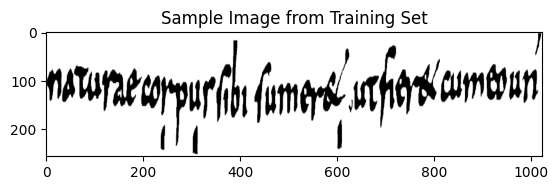

In [30]:
plt.imshow(X_train[10], cmap="gray", vmin=0, vmax=255)
plt.title("Sample Image from Training Set")
plt.show()

In [31]:
print("First entry in y_train:")
print(y_train[0])

First entry in y_train:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


---
The 'cnn_rnn'-model is comprised of an
- input layer
  - where images are read into with 64px, None and one channel
- A convolutional layer which is building 64, 3x3-filters
- Maxpooling to reduce parametersize

In [32]:
cnn_rnn = models.Sequential(
    [
        # CNN layers
        layers.Conv2D(
            64, (3, 3), padding="same", activation="relu", input_shape=(256, 1024, 1)
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),  # → (128, 512, 64)
        layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),  # → (64, 256, 128)
        # Reshape for RNN
        layers.Reshape(target_shape=(256, 64 * 128)),  # → (batch, 256, 8192)
        # RNN layers
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        # Output layer
        layers.Dense(num_classes, activation="softmax"),
    ]
)


cnn_rnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

cnn_rnn.summary()

/home/ucloud/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 256, 1024, 64)  │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 128, 512, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 512, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 256, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 256, 8192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256, 512)       │    17,303,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256, 512)       │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256, 84)        │        43,092 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,996,052 (72.46 MB)

 Trainable params: 18,996,052 (72.46 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
#! Commented out to avoid running the model training
# # Fit the model
cnn_rnn.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 468s 42s/step - accuracy: 0.6068 - loss: 2.0233 - val_accuracy: 0.8175 - val_loss: 1.0067
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 478s 43s/step - accuracy: 0.8225 - loss: 0.9900 - val_accuracy: 0.8175 - val_loss: 0.9891
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 483s 44s/step - accuracy: 0.8155 - loss: 1.0122 - val_accuracy: 0.8175 - val_loss: 0.9448
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 479s 44s/step - accuracy: 0.8182 - loss: 0.9004 - val_accuracy: 0.8175 - val_loss: 0.9056
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 479s 44s/step - accuracy: 0.8216 - loss: 0.8160 - val_accuracy: 0.8210 - val_loss: 0.7137
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 486s 44s/step - accuracy: 0.8272 - loss: 0.6990 - val_accuracy: 0.8249 - val_loss: 0.6902
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 485s 44s/step - accuracy: 0.8280 - loss: 0.6704 - val_accuracy: 0.8285 - val_loss: 0.6623
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 483s 44s/step - accuracy: 0.8310 - loss: 0.6561 - val_accuracy: 0.

In [34]:
cnn_rnn.save("CNN_RNN_model.keras")